In [1]:
#!/usr/bin/python
from __future__ import absolute_import

import sys
sys.path.append("../../")

import numpy as np
#from tensorflow import keras
import pickle
import argparse
import copy
import random
import time
import torch

from shapley.apps import Label, Poisoning
from shapley.loader import FashionMnist, MNIST, Flower
from shapley.measures import KNN_Shapley, KNN_LOO, G_Shapley, LOO, TMC_Shapley, FastWeightedShapley
from shapley.utils.plotter import LabelPlotter, PoisoningPlotter

%matplotlib inline
# import global vars
from init import set_seed

seed = 1023
set_seed(seed)
torch.backends.cudnn.enabled = False

2023-08-20 13:47:49.617635: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-20 13:47:50.701900: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
non-resource variables are not supported in the long term
Loaded Global Variables!


/home/sidtandon/Sid/GitRepo/fast-data-shapley/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
torch.cuda.is_available()

In [2]:
num_train = 60000
num_test = 10000
datasource = "fmnist"
model_family = "resnet18"
app_name = "noisy_label"
model_checkpoint_dir = f"../../checkpoints/{app_name}/{datasource}"


#loader = MNIST(num_train=num, one_hot=False, shuffle=True, by_label=True)
loader = FashionMnist(num_train=num_train,num_test = num_test, all_classes=True, seed = seed)
# loader = Flower(num_train=num)
X_data, y_data, X_test_data, y_test_data = loader.prepare_data()
print(X_test_data.shape, X_data.shape)

(10000, 1, 28, 28) (60000, 1, 28, 28)


In [ ]:
import pickle
start = time.time()

measure_fast_weighted_shapley = FastWeightedShapley(K = 5, model_checkpoint_dir=model_checkpoint_dir)
app = Label(X_data, y_data, X_test_data, y_test_data, model_family=model_family, model_checkpoint_dir=model_checkpoint_dir)
with open("./app_label.pkl", 'wb') as outp:
    pickle.dump(app, outp, pickle.HIGHEST_PROTOCOL)

res = app.run(measure_fast_weighted_shapley)
res_fwshapley = np.zeros(len(res))
for i in range(len(res)): res_fwshapley[i] = res[i][0]
print('Fast Weighted Shapley compute time: ',time.time()-start)
np.save(f"../../results/{app_name}/{datasource}/fw_shapley_results.npy", res)

### Get data improtance using other measures

In [ ]:
if 'app' not in locals() or not app:
    with open('./app_label.pkl', 'rb') as inp:
        app = pickle.load(inp)

measure_KNN = KNN_Shapley(K=5)
measure_KNNLOO = KNN_LOO(K=5)
measure_gshap = G_Shapley()
measure_tmc = TMC_Shapley()
measure_LOO = LOO()

dir_path = f"../../results/{app_name}/{datasource}"

start = time.time()
res_knn = app.run(measure_KNN)
print('KNN Shapley compute time: ',time.time()-start)
np.save(f"{dir_path}/knn_shapley_results.npy", res_knn)

start = time.time()
res_knnloo = app.run(measure_KNNLOO)
print('KNN LOO compute time: ',time.time()-start)
np.save(f"{dir_path}/res_knnloo.npy", res_knnloo)

start = time.time()
res_gshap = app.run(measure_gshap)
print('GShapley compute time: ',time.time()-start)
np.save(f"{dir_path}/g_shapley_results.npy", res_gshap)

# start = time.time()
# res_tmc = app.run(measure_tmc)
# print('TMC Shapley compute time: ',time.time()-start)
# np.save(f"{dir_path}/tmc_results.npy", res_tmc)

# start = time.time()
# res_loo = app.run(measure_LOO)
# print('LOO compute time: ',time.time()-start)


### Plot importances

In [ ]:
import matplotlib.pyplot as plt
plt.hist(res_fwshapley)

In [6]:
res_fwshapley

array([ 0.02647462,  0.02036835,  0.02544929, ...,  0.02673672,
       -0.01912925,  0.01513801])

name: KNN-Shapley  ,cnt:  6000  ,total:  6000
name: G-Shapley  ,cnt:  6000  ,total:  6000
name: KNN-LOO  ,cnt:  6000  ,total:  6000
name: FW-Shapley  ,cnt:  6000  ,total:  6000


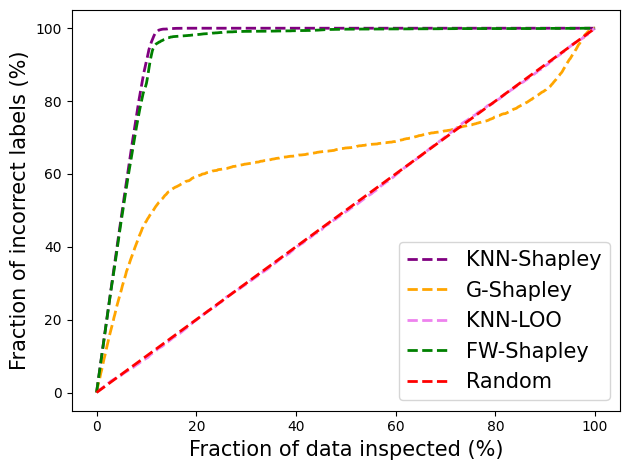

In [7]:
# res_fwshapley = res[:,0]
# dir_path = f"../../results/{app_name}/{datasource}"
# res_fwshapley = np.load(f"{dir_path}/fw_shapley_results.npy")[:,0]
# res_knn = np.load(f"{dir_path}/knn_shapley_torch_results.npy")
# res_gshap = np.load(f"../../results/fmnist/g_shapley_results.npy")
# res_knnloo = np.load(f"{dir_path}/res_knnloo.npy")

LabelPlotter(app, 
                  ('KNN-Shapley',res_knn),
                  ('G-Shapley',res_gshap),
                  ('KNN-LOO',res_knnloo),
                 ('FW-Shapley', res_fwshapley)
                 ).plot()

In [ ]:
# High importance images
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image

indexes = np.argsort(res_fwshapley)


plt.figure(figsize=(20, 20))


for i, index in enumerate(indexes[:20]):
    inst_x = X_data[index]
    inst_x = inst_x.reshape(28, 28)
    # inst_x = Image.fromarray(np.uint8(inst_x))
    plt.subplot(10, 5, i+1)
    plt.imshow(inst_x, cmap='gray')
    plt.title(y_data[index])

plt.savefig(f"./figs/{datasource}/fw-shapley.png")

In [ ]:
# High importance images

import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image

indexes = np.argsort(-res_knn)
plt.figure(figsize=(20, 20))
for i, index in enumerate(indexes[:20]):
    inst_x = X_data[index]
    inst_x = inst_x.reshape(28, 28)
    # inst_x = Image.fromarray(np.uint8(inst_x))
    plt.subplot(10, 5, i+1)
    plt.imshow(inst_x, cmap='gray')
    plt.title(y_data[index])
